In [114]:
import pandas as pd
import numpy as np
import os, sys

# Data upload

In [228]:
# upload a dataset 

file_path_Evgeny = os.path.join(sys.path[0], "dialogues_v3_Evgeny.xlsx")
file_path_Tijs = os.path.join(sys.path[0], "dialogues_v3_Tijs.xlsx")

col_names = ['id', 'conv_id' 'pagetitle', 'orig_user', 'reply_user', 'orig', 'reply',
       'disagreement', 'orig_id', 'reply_id', 'orig_toxicity',
       'orig_severe_toxicity', 'reply_toxicity', 'reply_severe_toxicity',
       'conv_id', 'COP', 'COP_flag', 'COP_why', 'FCG', 'FCG_flag',
       'FCG_why', 'RT', 'RT_flag', 'RT_why', 'PS',
       'PS_flag', 'PS_why', 'Overall comment', 'escalated']

csv_parameters = {
        'header' : 1, 
        'names' : col_names, 
        'index_col' :'id', 
        'convert_float' : True}

df_Evgeny = pd.read_excel(file_path_Evgeny, **csv_parameters)
df_Tijs = pd.read_excel(file_path_Tijs, **csv_parameters)

# substitute in Tijs's file, column 'diisagreement': 0,1 = 1,0
df_Tijs.disagreement.replace({
    0:1,
    1:0
}, inplace = True)

# in df_Evgeny, put disagreement == 0 if COP is not NA
def add_disagreement_rate(row):
    if row['COP'] in [0,1]:
        return 0
    elif row['disagreement'] == 1:
        return 1
df_Evgeny['disagreement'] = df_Evgeny.apply(lambda rows: add_disagreement_rate(rows), axis = 1)

df = pd.concat([df_Evgeny, df_Tijs])

df = df.convert_dtypes()

# Fistly, calculate a summ_PT parameter
df['summ_PT'] = df.COP + df.FCG + df.RT + df.PS

In [229]:
# choose appropriate columns. drop lines without disagreement.
df_ess = df[['orig', 'reply', 'COP', 'FCG', 'RT', 'PS', 'escalated', 'conv_id', 'disagreement', 'summ_PT']].dropna()
labels = ['COP', 'FCG', 'RT', 'PS']

In [230]:
df_ess.head()

,orig,reply,COP,FCG,RT,PS,escalated,conv_id,disagreement,summ_PT
id,,,,,,,,,,
1548,Neutrality\nIf the neutrality of this article...,That's true. The problem with the article is t...,1,0,1,0,0,126310761.67.67,0,2
1549,That's true. The problem with the article is t...,"As this is an emotionally laden subject, I don...",1,0,0,0,0,126310761.67.67,0,1
1550,"As this is an emotionally laden subject, I don...","For the official language thing check, Talk:Ic...",0,1,1,1,0,126310761.67.67,0,3
1551,"For the official language thing check, Talk:Ic...","I did not have the USA in mind, when I wrote t...",1,0,1,1,0,126310761.67.67,0,3
1552,"For the official language thing check, Talk:Ic...",PS: I had already read the discussion you refe...,1,0,1,0,0,126310761.67.67,0,2


# Data Analysis

The first hypothesis claims that the developed NLP model will predict the level of Perspective-Taking in utterances significantly better than the baseline bag-of-words approach. 

Secondly, we hypothesize that higher Perspective-Taking scores in the discussion will lead to the lower rate of the moderator summons. 

In third, the length of the discussion will be negatively correlated with the Perspective-Taking scores, as higher Perspective-Taking should lead to higher constructiveness of a discussion and, as a result, to a faster agreement.

The fourth hypothesis states that the level of Perspective-Taking in a discussion will be dependent on the Perspective-Taking level in the first reply. This hypothesis is based on the idea that there are communication patterns that promote empathy in response (Pfeil & Zaphiris, 2007). We suggest that exercising Perspective-Taking at the beginning of the discussion will promote a similar pattern in subsequent answers.   


In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 

### Second hypothesis

(array([ 95., 229., 585., 647., 118.]),
 array([0.0, 0.8, 1.6, 2.4000000000000004, 3.2, 4.0], dtype=object),
 <a list of 5 Patch objects>)

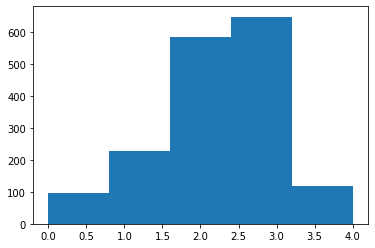

In [216]:
plt.hist(df_ess['summ_PT'], bins = 5)

In [217]:
escalated_PT = df_ess[df_ess.escalated == 1]['summ_PT']
non_escalated_PT = df_ess[df_ess.escalated == 0]['summ_PT']

(array([ 79., 182., 488., 559., 103.]),
 array([0.0, 0.8, 1.6, 2.4000000000000004, 3.2, 4.0], dtype=object),
 <a list of 5 Patch objects>)

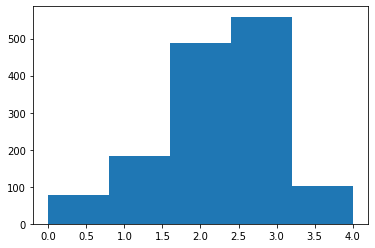

In [218]:
plt.hist(non_escalated_PT, bins = 5)

(array([16., 47., 97., 88., 15.]),
 array([0.0, 0.8, 1.6, 2.4000000000000004, 3.2, 4.0], dtype=object),
 <a list of 5 Patch objects>)

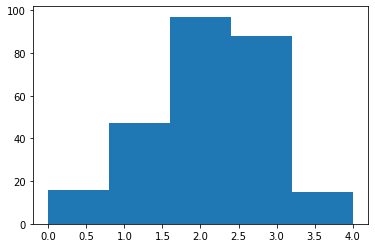

In [219]:
plt.hist(escalated_PT, bins = 5)

In [220]:
e_m = np.mean(escalated_PT)

In [221]:
e_sd = np.std(escalated_PT)

In [222]:
stats_lev = stats.levene(escalated_PT, non_escalated_PT, center = 'median') # ‘median’ : Recommended for skewed (non-normal) distributions>
# equal variance is supported
stats_lev

LeveneResult(statistic=0.6021291884777888, pvalue=0.43787653979149366)

In [223]:
ne_m = np.mean(non_escalated_PT)

In [224]:
ne_sd = np.std(non_escalated_PT)

In [225]:
h2_ttest = stats.ttest_ind(escalated_PT, non_escalated_PT, equal_var = True)
h2_ttest

Ttest_indResult(statistic=-2.331643999984482, pvalue=0.019837686676896973)

In [226]:
# print results
print(
f"Levene's test was conducted to test the equality of variance hypothesis \
for the utterances in escalated and non-escalated conversations. The test \
indicated equal variance (F = {stats_lev[0]:.2}, p = {stats_lev[1]:.2}). \
Thus, t-test was applied to test the second hypothesis. The null hypothesis \
states that there is no difference between perspective-taking scores for the \
utterances in escalated and non-escalated conversations. The t-test results rejected \
the null-hypothesis: there is a significant difference between escalated (M = {e_m:.2}, sd = {e_sd:.2}) \
and non-escalated (M = {ne_m:.2}, sd = {ne_sd:.2}) conversations: t = {h2_ttest[0]:.2}, p = {h2_ttest[1]:.2}, \
df = {len(non_escalated_PT) + len(escalated_PT) - 1}."
)

Levene's test was conducted to test the equality of variance hypothesis for the utterances in escalated and non-escalated conversations. The test indicated equal variance (F = 0.6, p = 0.44). Thus, t-test was applied to test the second hypothesis. The null hypothesis states that there is no difference between perspective-taking scores for the utterances in escalated and non-escalated conversations. The t-test results rejected the null-hypothesis: there is a significant difference between escalated (M = 2.1, sd = 0.98) and non-escalated (M = 2.3, sd = 0.97) conversations: t = -2.3, p = 0.02, df = 1673.


### Third hypothesis

In third, the length of the discussion will be negatively correlated with the Perspective-Taking scores, as higher Perspective-Taking should lead to higher constructiveness of a discussion and, as a result, to a faster agreement.

In [235]:
df3 = df[['orig', 'reply', 'COP', 'FCG', 'RT', 'PS', 'escalated', 'conv_id', 'disagreement', 'summ_PT']]

df3 = df3[~df.disagreement.isna()]

In [240]:
df3_grouped = df3.groupby('conv_id').agg(
    {
        'summ_PT':'mean',
        'escalated':['count', 'max']
    })

In [245]:
df3_grouped.dropna(inplace=True)

In [246]:
df3_grouped

summ_PT escalated    
                           mean     count max
conv_id                                      
102560318.1367.1367    3.000000         2   0
102988832.9898.9898    2.500000        11   0
103078206.4910.4910    1.000000         2   0
103107618.86212.86212  2.642857        16   0
103346049.16573.16573  2.571429         7   0
...                         ...       ...  ..
770472134.38557.38557  2.000000        29   1
771783260.12657.12657  1.473684        19   1
781245470.3456.3456    2.714286         9   1
785620210.22955.22955  2.000000        13   1
788732140.42233.42233  1.942857        37   1

[357 rows x 3 columns]

In [294]:
df3_PT = df3_grouped['summ_PT']['mean']
df3_count = df3_grouped['escalated']['count']

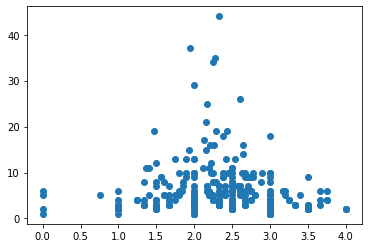

In [295]:
plt.scatter(df3_PT, df3_count)

In [313]:
corr = stats.spearmanr(df3_PT, df3_count)

In [316]:
print(
f'To test the third hypothesis, the mean perspective-taking score and the number of utterances were calculated for \
each conversation. Then, Spearman correlation coefficient was calculated. The results showed that there is no \
significant correlation between the number of utterances and perspective-taking scores: r = {corr[0]:.2}, \
p = {corr[1]:.2}, N = {len(df3_grouped)}.'
)

To test the third hypothesis, the mean perspective-taking score and the number of utterances were calculated for each conversation. Then, Spearman correlation coefficient was calculated. The results showed that there is no significant correlation between the number of utterances and perspective-taking scores: r = -0.079, p = 0.14, N = 357.


### Fourth hypothesis

The fourth hypothesis states that the level of Perspective-Taking in a discussion will be dependent on the Perspective-Taking level in the first reply. This hypothesis is based on the idea that there are communication patterns that promote empathy in response (Pfeil & Zaphiris, 2007). We suggest that exercising Perspective-Taking at the beginning of the discussion will promote a similar pattern in subsequent answers.

In [351]:
df.head()
def first_reply_PT(x):
    return x.iloc[0]
def my_mean(x):
    return np.mean(x.iloc[1:])
df.disagreement.value_counts()

0    1681
1     480
Name: disagreement, dtype: Int64

In [352]:
df4 = df3.groupby('conv_id').agg(
{
    'summ_PT':[first_reply_PT, my_mean] 
})
df4.dropna(inplace = True)

In [353]:
first_reply = df4['summ_PT']['first_reply_PT']
mean = df4['summ_PT']['my_mean']

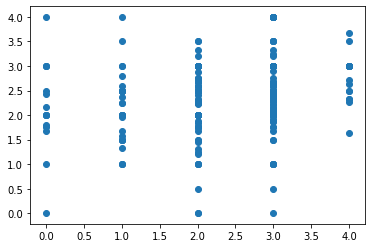

In [354]:
plt.scatter(first_reply, mean)

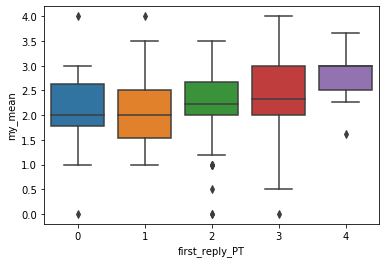

In [369]:
import seaborn as sns
sns.boxplot(x = first_reply, y = mean)

In [355]:
stats.spearmanr(first_reply, mean)

SpearmanrResult(correlation=0.21850617741840914, pvalue=0.00036654083527436606)

In [365]:
from sklearn.linear_model import LinearRegression

X = np.array(first_reply).reshape(-1, 1)
y = np.array(mean)

# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X, y)

In [368]:
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = 1.9693533782441446
betas = [0.15022315]


In [ ]:
print(
f'')